Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Sam Hamers, 2014708"
COLLABORATORS = ""

---

# Programming Cournot competition

In this notebook, we will solve a duopoly Cournot model using python. This illustrates how to optimize in python and how to solve equations.



# Model



In this notebook we show how a Cournot model can be solved numerically.

We start by importing the relevant libraries.

In [2]:
from scipy import optimize,arange
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

We assume that (inverse) demand is linear:
$$
p_i(q_i,q_j) = 1-aq_i-bq_j
$$
where $0<b \leq a$.

Further, firms have constant marginal costs:
$$
c_i(q) = c_i q
$$
Then we can write profits as:
$$
\pi_i(q_i,q_j) = (p_i(q_i,q_j)-c_i)q_i
$$

We can define these functions in python as follows.

In [3]:
def p(q1,q2):
    return 1-a*q1-b*q2

def costs(q,c):
    return c*q

def profits(demand_function,cost_function,c,q1,q2):
    return demand_function(q1,q2)*q1-cost_function(q1,c)

Note that in the last function `profits`, we define this function to be a function of the `demand_function` and the `cost_function`. Later we substitute $p(q_1,q_2)$ for the demand function and $c(q,c)$ for the cost function.  

We assume that the firms produce perfect substitutes (homogenous goods).

In [4]:
a = 1
b = 1

In equilibrium,each firm maximizes its profits taking the output level of its competitor as given. This is how we are going to model firms. That is, we do not take first order conditions (see appendix for this approach); instead we maximize profits directly.

A minor problem here is that python does not feature maximization routines; there are only minimization routines. Hence, if we want to maximize profits, we need to minimize `minus profits`. In the following code block, we minimize $-profits$ for firm 1 given an output level $q_2$ for the other firm. This is, in fact, firm 1's reaction function. From `optimize` we use the function `fminbound` to find the minimum of $-profits$. We specify the function `profits`, with functions `p` and `costs` as defined above. The function call to `reaction` specifies `q2` and `c1`. The only variable left to vary is $q_1$ which we denote by $x$ in the "lambda"-function. Further, we specify the interval where the optimal $q_1$ has to be found; $[0,1]$ in this case. Google to see what `full_output` does in this case.

Then we define the function `fixed_point`: each firm's output choice is optimal *given* the output of the other firm. Note that the function `reaction` can be used for both firm 1 and firm 2; only the arguments differ for the firms, but the function itself is the same.

The function `fixed_point` takes two (vector) arguments: a vector $q$ of output levels and $c$ of cost levels. With the indexing conventions in python, $q[0]$ is the first element of $q$ and hence a natural choice for $q_1$; similarly, $q[1]$ corresponds to $q_2$. The same logic applies to $c$.

From `optimize` (which was imported above from `scipy`), we use `fsolve` to find the $q$ where `fixed_point(q,c)` equals 0. We provide an initial guess for this vector $q$. We solve the model for the case where $c_1=c_2=0$.



In [5]:
def reaction(q2,c1):
    q1 =  optimize.fminbound(lambda x: -profits(p,costs,c1,x,q2),0,1,full_output=1)
    return q1[0]

def fixed_point(q,c):
    return [q[0]-reaction(q[1],c[0]),q[1]-reaction(q[0],c[1])]

initial_guess = [0,0]

optimize.fsolve(lambda q: fixed_point(q,[0,0]), initial_guess)

array([ 0.33333333,  0.33333333])


### Exercise

Derive that total output equals 0.5 if $c_1=0.2$ and $c_2=0.3$.


In [27]:
optimize.fsolve(lambda q: fixed_point(q,[0.2,0.3]), initial_guess)

array([ 0.3,  0.2])

Now we are going to do a number of simulations for different cost levels of the two firms. In order to store all the outcomes of these simulations, we create a pandas dataframe. 



In [19]:
columns = ['c_1','c_2','q_1','q_2']
df_simulations = pd.DataFrame(columns=columns)
range_c = arange(0,0.51,0.01)
counter = 0
for i in range(len(range_c)):
    for j in range(len(range_c)):
        counter = counter +1
        c_1 = range_c[i]
        c_2 = range_c[j]
        df_simulations.loc[counter] = [c_1, c_2, optimize.fsolve(lambda q: fixed_point(q,[c_1,c_2]), initial_guess)[0],optimize.fsolve(lambda q: fixed_point(q,[c_1,c_2]), initial_guess)[1]]

    

### Exercise

Explain the code above. [hint: use the pandas command to give you the first couple of rows of a dataframe to understand what the code above generates]

It checks for 51 (=len(range_c)) values of c_1 and c_2 and outputs the corresponding q_1 and q_2

In [29]:
df_simulations.head()

,c_1,c_2,q_1,q_2
1,0.0,0.00,0.333333,0.333333
2,0.0,0.01,0.336667,0.326667
3,0.0,0.02,0.340000,0.320000
4,0.0,0.03,0.343333,0.313333
5,0.0,0.04,0.346667,0.306667


We view the dataframe defined above as an economy with different sectors. In each sector there is a duopoly with firms with different costs. We will analyze this cross section of industries below. We start with some summary statistics of this economy.

### Exercise

Use the pandas command that gives you the mean, median and quartiles.

In [32]:
df_simulations.describe()

,c_1,c_2,q_1,q_2
count,2601.000000,2601.000000,2601.000000,2601.000000
mean,0.250000,0.250000,0.250000,0.250000
std,0.147224,0.147224,0.109735,0.109735
min,0.000000,0.000000,0.000006,0.000006
25%,0.120000,0.120000,0.166667,0.166667
50%,0.250000,0.250000,0.250000,0.250000
75%,0.380000,0.380000,0.333333,0.333333
max,0.500000,0.500000,0.499997,0.499997


Below we will make some plots using the matplotlib library. However, in pandas it is possible to plot from a dataframe directly. Then pandas plots as a function of the index of the dataframe. However, we have not yet set an index. In the following command we define the combination of $c_1$ and $c_2$ as the index. Then with `loc[0.0]` we fix the first index ($c_1$) to 0.0. We indicate that we want to plot $q_1$ and $q_2$ and then add the `plot()` method.

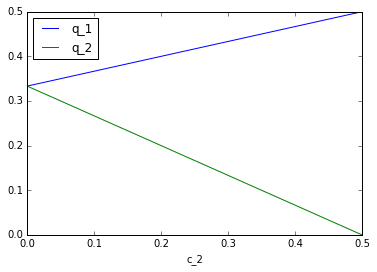

In [40]:
#plt.style.use('seaborn')
df_simulations.set_index(['c_1','c_2']).loc[0.0][['q_1','q_2']].plot()

### Exercise

Why is $q_1$ increasing in this graph and $q_2$ decreasing?

The costs of firm 2 have gone up, which means they will produce less. Meaning firm 1 can produce (and sell) more.

Once we have a dataframe, we can calculate new variables using the columns in the existing dataframe. For instance, to add a column with total output, we do the following:

In [43]:
df_simulations['Q'] = df_simulations['q_1']+df_simulations['q_2']
df_simulations.head()

,c_1,c_2,q_1,q_2,Q
1,0.0,0.00,0.333333,0.333333,0.666667
2,0.0,0.01,0.336667,0.326667,0.663333
3,0.0,0.02,0.340000,0.320000,0.660000
4,0.0,0.03,0.343333,0.313333,0.656667
5,0.0,0.04,0.346667,0.306667,0.653333


### Exercise

Calculate equilibrium prices. That is, define the new column `df_simulations['P']`.

In [48]:
df_simulations['P'] = p(df_simulations['q_1'],df_simulations['q_2'])

#or df_simulations['P'] = 1-df_simulations['q_1']-df_simulations['q_2']

%xdel


### Exercise

Include the profits of firm 1 and firm 2 in the dataframe.

In [49]:
df_simulations['Profit_1'] = df_simulations['P']*df_simulations['q_1']-df_simulations['c_1']*df_simulations['q_1']
df_simulations['Profit_2'] = df_simulations['P']*df_simulations['q_2']-df_simulations['c_2']*df_simulations['q_2']
df_simulations.head()

,c_1,c_2,q_1,q_2,Q,P,Profit_1,Profit_2
1,0.0,0.00,0.333333,0.333333,0.666667,0.333333,0.111111,0.111111
2,0.0,0.01,0.336667,0.326667,0.663333,0.336667,0.113344,0.106711
3,0.0,0.02,0.340000,0.320000,0.660000,0.340000,0.115600,0.102400
4,0.0,0.03,0.343333,0.313333,0.656667,0.343333,0.117878,0.098178
5,0.0,0.04,0.346667,0.306667,0.653333,0.346667,0.120178,0.094044


A popular competition measure is the Herfindahl index. The equation for this index is given by
$$
H = \sum_{i=1}^n \left(\frac{q_i}{\sum_{j=1}^n q_j} \right)^2
$$
where $\frac{q_i}{\sum_{j=1}^n q_j}$ gives the market share of firm $i$ in a market with $n$ firms (and homogenous products).

In words, the Herfindahl index equals the sum of firms' squared market shares.

For our duopoly model, we can write
$$
H = \left( \frac{q_1}{Q} \right)^2 + \left( \frac{q_2}{Q} \right)^2
$$
where total market ouput is given by $Q=q_1+q_2$.

Lower values of $H$ are often seen as indicating more intense competition in a market. Indeed, if there is a monopoly in a market, one firm has market share equal to 1 and all other firms have market share equal to 0. Then we have $H=1$. Instead, in a duopoly market with symmetric firms we have $H = 0.5$.

Hence, the closer $H$ is to 0.5, the more competitive the duopoly market according to this reasoning.

### Exercise

Add the Herfindahl index to the dataframe. That is, add the column `df_simulations['H']`.

In [60]:
df_simulations['H'] = (df_simulations['q_1']/df_simulations['Q'])**2+(df_simulations['q_2']/df_simulations['Q'])**2
df_simulations.head()

,c_1,c_2,q_1,q_2,Q,P,Profit_1,Profit_2,H
1,0.0,0.00,0.333333,0.333333,0.666667,0.333333,0.111111,0.111111,0.500000
2,0.0,0.01,0.336667,0.326667,0.663333,0.336667,0.113344,0.106711,0.500114
3,0.0,0.02,0.340000,0.320000,0.660000,0.340000,0.115600,0.102400,0.500459
4,0.0,0.03,0.343333,0.313333,0.656667,0.343333,0.117878,0.098178,0.501044
5,0.0,0.04,0.346667,0.306667,0.653333,0.346667,0.120178,0.094044,0.501874


Once you have added $H$ to the dataframe, we can make a scatter plot of $H$ against $P$. Each point (dot) in this plot is an industry in our economy in the dataframe.

Above we explained why people tend to interpret low $H$ as a competitive industry. Another interpretation of a competitive industry is, of course, that its price is low.

Run the code below, to view the cross section variation in $H$ and equilibrium price $P$.

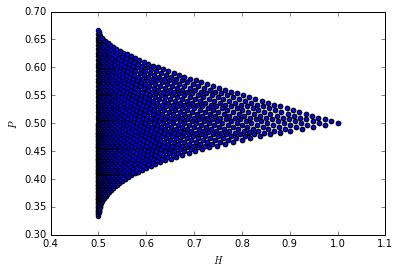

In [63]:
plt.scatter(df_simulations['H'],df_simulations['P'])
plt.xlabel('$H$')
plt.ylabel('$P$')
plt.show()

### Exercise

Use this figure above to discuss the role of the Herfindahl index as a competition measure. Do you agree with the interpretation that lower $H$ should be interpreted as more competitive?

It's not always the case. There will be a difference between efficient and inefficient firms. It's uncertain how these firms will react.

### Exercise

Run the code below. This code uses the pandas dataframe to plot a figure directly. You have seen this code already above where we gave an explanation of how the code works. Plot the graph. Does this help you to get an intuition for the relation between $H$ and $P$?

YOUR ANSWER HERE

In [15]:
df_simulations.set_index(['c_1','c_2']).loc[0.2][['H','Q']].plot()

NameError: name 'df_simulations' is not defined

## Appendix

The model we solve above is actually simple enough to solve analytically. In case you are wondering, this appendix shows how to solve the model. This appendix is optional; you do not need to read it for the course.


Assume we have a linear demand curve $p_i(q_i,q_j)=1-a q_i - b q_j$ and costs $c_i(q)=c_i q$, where $q_i$ denotes firm $i$'s output on the market.

Firm $i$'s profit is written as $\pi(q_i,q_j)=(1-a q_i-b q_j)q_i-c_i q_i$ with $j \neq i$.

The two first order conditions for firms 1 and 2 are derive by taking the derivative of $\pi_1$ w.r.t. $q_1$ and $\pi_2$ w.r.t. $q_2$. These equations can be written as:
$$
1-2a q_1-b q_2-c_1 = 0
$$
and
$$
1-2 a q_2-b q_1-c_2 = 0
$$

Then we can solve these two equations in the unknowns $q_1,q_2$. However, we usually take a step in between and define the reaction functions. That is, we solve the optimal $q_i$ as a function of $q_j$:
$$
q_i = \frac{1}{2a}(1-c_i-b q_j)
$$
Or, equivalently, we define $i$'s reaction function as 
$$
R_i(q_j) = \frac{1}{2a}(1-c_i-b q_j)
$$

We have an equilibrium if $q_1 = R_1(q_2)$ and $q_2 = R_2(q_1)$. Or in matrix notation, the equilibrium is given by $q_1,q_2$ such that
$$
\begin{pmatrix} q_1\\ q_2\end{pmatrix} = \begin{pmatrix} R_1(q_2)\\ R_2(q_1)\end{pmatrix}
$$

If both firms have the same costs $c_1=c_2$, there is a symmetric equilibrium given by $q=R(q)$.

To calculate the equilibrium, we need to find a so called fixed point of the vector function $R(q)$. This can be seen as follows.

Define the function (or mapping) $q \rightarrow R(q)$ with $q \in \Re^2$ and 

$$
R(q) = \begin{pmatrix} R_1(q_2)\\ R_2(q_1)\end{pmatrix}
$$

A fixed point of this function is defined as a vector $q$ such that $q=R(q)$. In words, $q_1$ is the optimal reaction to $q_2$ and $q_2$ is the optimal reaction to $q_1$. That is, the vector $q$ is a Nash equilibrium. Each firm $i$ chooses its optimal output level $q_i$, given the choice by the other firm $q_j$.
